In [43]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LassoCV
from sklearn.model_selection import TimeSeriesSplit

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame
from energy_consumption.models.lasso import functions

### 1. Include all desired features 
* make sure they are still reasonable
* Assume Lasso can handle this 

In [2]:
24*365*5

43800

In [44]:
# important to standardize X for lasso regression
# use derived opt for quantReg
energydata = extract_all_features.get_energy_and_standardized_features2(
    lasso=True)

y = energydata[['energy_consumption']]
X = energydata.drop(columns=['energy_consumption'])
X.insert(loc=0, column='constant', value=1)

did you update weather and index?
2016-12-26 00:00:00
2023-11-23 12:00:00


In [3]:
X

,constant,sun_hours,tavg,wspd,index,population,hour_1,hour_2,hour_3,hour_4,...,year_2016,year_2017,year_2018,year_2019,year_2020,year_2021,year_2022,year_2023,year_2024,holiday
date_time,,,,,,,,,,,,,,,,,,,,,
2016-12-26 00:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2016-12-26 01:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2016-12-26 02:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2016-12-26 03:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2016-12-26 04:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 08:00:00,1,-1.266314,-1.520067,-0.580195,-1.968927,1.766780,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2023-11-22 09:00:00,1,-1.266314,-1.520067,-0.580195,-1.968927,1.766780,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2023-11-22 10:00:00,1,-1.266314,-1.520067,-0.580195,-1.968927,1.766780,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [45]:
correlation_matrix = X.corr()

# Find pairs of variables with absolute correlation value greater than 0.1
high_corr_pairs = [(i, j) for i in range(correlation_matrix.shape[0])
                   for j in range(i+1, correlation_matrix.shape[1])
                   if abs(correlation_matrix.iloc[i, j]) > 0.7]

# Create a copy of the original predictor matrix
X_pol = X.copy()

# Add interaction terms for selected pairs
for pair in high_corr_pairs:
    col1, col2 = X.columns[pair[0]], X.columns[pair[1]]
    name = f"{col1}_{col2}"
    X_pol[name] = X_pol[col1] * \
        X_pol[col2]

# add polynomials 
X_pol['tavg_2'] = X_pol['tavg']**2
X_pol['wspd_2'] = X_pol['wspd']**2
X_pol['sun_hours_2'] = X_pol['sun_hours']**2

In [5]:
X_pol

,constant,sun_hours,tavg,wspd,index,population,hour_1,hour_2,hour_3,hour_4,...,year_2020,year_2021,year_2022,year_2023,year_2024,holiday,sun_hours_tavg,tavg_2,wspd_2,sun_hours_2
date_time,,,,,,,,,,,,,,,,,,,,,
2016-12-26 00:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,0,0,0,0,...,0,0,0,0,0,1,0.771869,0.264847,3.959029,2.249536
2016-12-26 01:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,1,0,0,0,...,0,0,0,0,0,1,0.771869,0.264847,3.959029,2.249536
2016-12-26 02:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,0,1,0,0,...,0,0,0,0,0,1,0.771869,0.264847,3.959029,2.249536
2016-12-26 03:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,0,0,1,0,...,0,0,0,0,0,1,0.771869,0.264847,3.959029,2.249536
2016-12-26 04:00:00,1,-1.499845,-0.514633,1.989731,-0.780066,-1.726775,0,0,0,1,...,0,0,0,0,0,1,0.771869,0.264847,3.959029,2.249536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-22 08:00:00,1,-1.266314,-1.520067,-0.580195,-1.968927,1.766780,0,0,0,0,...,0,0,0,1,0,0,1.924883,2.310605,0.336626,1.603552
2023-11-22 09:00:00,1,-1.266314,-1.520067,-0.580195,-1.968927,1.766780,0,0,0,0,...,0,0,0,1,0,0,1.924883,2.310605,0.336626,1.603552
2023-11-22 10:00:00,1,-1.266314,-1.520067,-0.580195,-1.968927,1.766780,0,0,0,0,...,0,0,0,1,0,0,1.924883,2.310605,0.336626,1.603552


In [6]:
y

,energy_consumption
date_time,
2016-12-26 00:00:00,41.81025
2016-12-26 01:00:00,39.73950
2016-12-26 02:00:00,38.78525
2016-12-26 03:00:00,38.96900
2016-12-26 04:00:00,39.18750
...,...
2023-11-22 08:00:00,65.75125
2023-11-22 09:00:00,67.40950
2023-11-22 10:00:00,68.26775


In [9]:
# Time-based split for time series data
tscv = TimeSeriesSplit(n_splits=50, test_size=100)  # Adjust the number of splits as needed

# Create LassoCV model with time series cross-validation
# let alphas = None to automatically compute best alpha
lasso_cv = LassoCV(cv=tscv,max_iter=1000)

# Fit the model on the scaled data
lasso_cv.fit(X_pol, y)

# Find the best alpha
best_alpha = lasso_cv.alpha_
print(f"Best alpha: {best_alpha}")

c:\Users\Maria\Documents\Setups\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1563: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha: 0.005958070524838339


In [10]:
lasso_best = Lasso(alpha=best_alpha)
lasso_best.fit(X_pol, y)
print(list(zip(lasso_best.coef_, X_pol)))

[(0.0, 'constant'), (-1.8026677662776331, 'sun_hours'), (-1.1466598391430414, 'tavg'), (0.8469484295218651, 'wspd'), (1.6045083021151594, 'index'), (-0.20819401324902348, 'population'), (-3.4719852820384776, 'hour_1'), (-4.3875071445456335, 'hour_2'), (-4.300066964785401, 'hour_3'), (-3.387536370168188, 'hour_4'), (-1.065027183110406, 'hour_5'), (3.7574278594694928, 'hour_6'), (8.203529784372929, 'hour_7'), (11.180777860230274, 'hour_8'), (12.664062495302609, 'hour_9'), (13.917684422860859, 'hour_10'), (14.997165937808886, 'hour_11'), (14.561437876469396, 'hour_12'), (13.356216075284864, 'hour_13'), (12.014813449126848, 'hour_14'), (11.20789248005293, 'hour_15'), (10.798670158563306, 'hour_16'), (11.815174736062184, 'hour_17'), (12.379337517086105, 'hour_18'), (11.784672280398373, 'hour_19'), (9.375296393184128, 'hour_20'), (6.834133923659343, 'hour_21'), (4.401481858358749, 'hour_22'), (0.8467073662119374, 'hour_23'), (1.1140716273527143, 'day_1'), (1.236359564248927, 'day_2'), (1.133

How to estimate forecast variance? 
--> estimate residuals for each forecast horizon (p=100). 
If we estimate more than 40, we can assume they are normal distributed. 

In [11]:
len(X_pol)

60541

In [54]:
# before: timeteriessplit with n_splits = 400, erst ab der Hälfte residuen berechnet (damit genug trainingsdaten)

# Perform time series split
tscv = TimeSeriesSplit(n_splits=300, test_size=100)
indexes = list(range(100))
residuals = pd.DataFrame()
for i in indexes:
    residuals[f'{i}'] = np.nan

for train_index, test_index in tscv.split(X_pol):

    # fit Lasso Regression with best alpha
    lasso = Lasso(alpha=0.006)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model on the scaled data
    lasso.fit(X_train, y_train)

    # estimate forecast means
    mean_est = lasso.predict(X_test)[indexes]

    # residuals based on horizon
    y_obs = np.array(y_test).flatten()
    residuals_est = y_obs - mean_est

    # safe
    residuals.loc[len(residuals)] = residuals_est

In [57]:
mean_values = residuals.mean(axis=0)
std_dev_values = residuals.std(axis=0)
std_dev_values
residuals2= residuals

In [58]:
# export residuals to avoid additional computational effort
residuals2.to_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals2.csv', index=False)

# check if residuals vary over time 
--> iterate over rows, check if there is trend in mean/variance of residuals
--> works

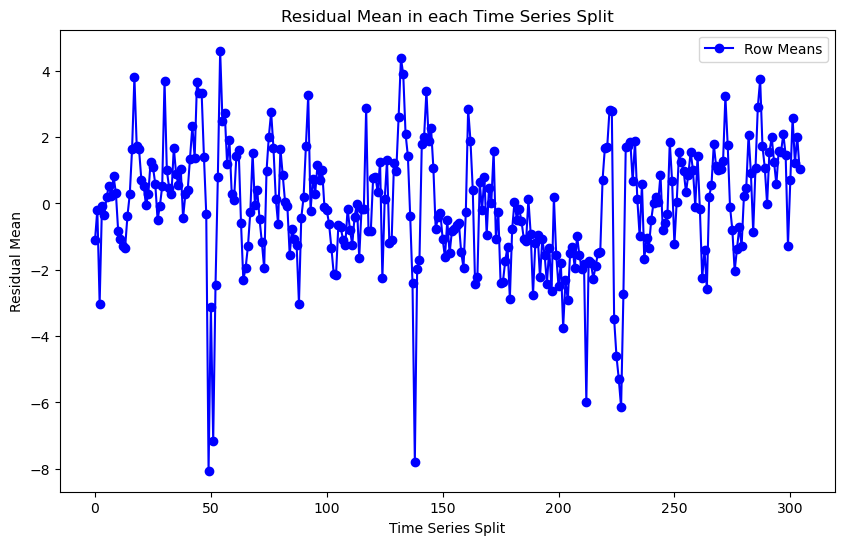

In [50]:
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df, replace the ellipsis (...) with your actual data
# For example, df = pd.DataFrame(...) with your data

# Calculate the mean of each row
row_means = residuals.mean(axis=1)

# Plot the mean values
plt.figure(figsize=(10, 6))
plt.plot(residuals.index, row_means, marker='o', linestyle='-',
         color='blue', label='Row Means')
plt.title('Residual Mean in each Time Series Split')
plt.xlabel('Time Series Split')
plt.ylabel('Residual Mean')
plt.legend()
plt.show()

# further variances to consider: temp, wspd and prodInd

estimated beta-coefficients: 
tavg: -1.1428
tavg_2: 0.6207
tavg_sun_hours: 0.4323
Wspd: 0.9242
wspd_2: 0.0204
index: 1.6932

add to variance: 
beta_hat^2 * var^2

In [51]:
# Note: the more comparisons we have, the better. However, we started very lately with including weather data. Therefore, this  is just a proxy.
from sklearn.preprocessing import StandardScaler

# proxy for tavg and wspd: 
weather_obs = pd.read_csv(
    'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/weather_01172024.csv')
weather_est = pd.read_csv(
    'C:/Users/Maria/Documents/Studium/Pyhton Projekte/PTSFC/energy_consumption/feature_selection/data/weather_010824.csv')

# Extract numeric columns for standardization (comparably the same length as training data for lasso regression)
cols = ['wspd', 'tavg']

# Standardize the columns
scaler = StandardScaler()

weather_est[cols] = scaler.fit_transform(
    weather_est[cols])
weather_obs[cols] = scaler.transform(
    weather_obs[cols])

# Rename and select relevant columns
weather_est_date = weather_est[['date', 'wspd', 'tavg']].rename(
    columns={'wspd': 'wspd_est', 'tavg': 'tavg_est'})
weather_obs_date = weather_obs[-16:][['date', 'wspd', 'tavg']
                                     ].rename(columns={'wspd': 'wspd_obs', 'tavg': 'tavg_obs'})

# Merge DataFrames based on the 'date' column
merged_df = pd.merge(weather_est_date, weather_obs_date,
                     on='date', how='inner')
merged_df['tavg_residual'] = merged_df['tavg_obs'] - merged_df['tavg_est']
merged_df['wspd_residual'] = merged_df['wspd_obs'] - merged_df['wspd_est']

var_to_add_wsp = merged_df['wspd_residual'].var() # (0.6418)
var_to_add_temp = merged_df['tavg_residual'].var()  # (0.0370)
var_to_add_wsp

# residuals do not really make sense since they are higher for later periods --> just add the same portion to each horizon

0.6417705151559819

Variance proxy for production index
--> Production index estimated with OLS --> estimate variance of OLS estimation

In [52]:
from energy_consumption.feature_selection.collect import production_index

# get unscaled energydata since OLS residuals are unscaled as well
energydata_unsc = extract_all_features.get_energy_and_features(
    lasso=True)[-54027:]
index_data_unsc = energydata_unsc['index']

var_est = index_data_unsc.var()
mean_est = index_data_unsc.mean()

residuals = production_index.merge_production_indexes(energydata_unsc)[2]

mean_res = residuals.mean()
var_est = residuals.var()

# standardize residuals
res_standardized = (residuals-mean_res)/(var_est)
var_to_add = res_standardized.var()
var_to_add # (0.0378)

did you update weather and index?
2016-12-26 00:00:00
2023-11-23 12:00:00


0.037842703248219776

tavg: -1.1466598391430414
tavg_2: 0.6308331583465531
tavg_sun_hours: 0.3831860403443813
Wspd: 0.035125692594820596
wspd_2: 0.035125692594820596
index: 1.6045083021151594

In [53]:
overall_variance_to_add = var_to_add * (1.6045083021151594)**2 + \
    var_to_add_temp**2*(1.1466598391430414+0.3831860403443813)**2 + (var_to_add_temp**2)*(0.6308331583465531)**2 + \
    var_to_add_wsp*0.035125692594820596**2 + \
    (var_to_add_wsp**2)*0.035125692594820596**2

overall_variance_to_add #(0.1025)

0.10246283393337681

Use alpha = 0.006 for Lasso Regression

In [24]:
def get_interaction_and_pol_terms(X): 

    # interaction term for sun_hours and tavg
    X['sun_hours_tavg'] = X['sun_hours'] * X['tavg']
            
    # Add polynomials
    X['tavg_2'] = X['tavg']**2
    X['wspd_2'] = X['wspd']**2
    X['sun_hours_2'] = X['sun_hours']**2

    return X

In [4]:
import pandas as pd
import numpy as np

from scipy.stats import norm
from math import sqrt

def get_quantiles(mean_est, quantiles=[0.025, 0.25, 0.5, 0.75, 0.975]):

    mean_est = np.array(mean_est)
    quantile_df = pd.DataFrame()

    # lasso variance
    residuals = pd.read_csv(
        'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals.csv')
    residual_std = np.sqrt(residuals.var(axis=0))

    # add variance due to forecasts of regressors
    std_to_add = sqrt(0.10246283393337681)

    for q in quantiles:
        if q < 0.5:
            quantile_df[f'q{q}'] = mean_est + \
                residual_std*norm.ppf(q, loc=0) - std_to_add
        elif q == 0.5:
            quantile_df[f'q{q}'] = mean_est
        else:
            quantile_df[f'q{q}'] = mean_est + \
                residual_std*norm.ppf(q, loc=0) - std_to_add

    return quantile_df

In [5]:
from math import sqrt
residuals = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\models\\lasso\\residuals.csv')
np.sqrt(residuals.var(axis=0))

0     3.215884
1     3.363386
2     3.553124
3     3.543380
4     3.221469
        ...   
95    3.423234
96    2.996263
97    3.077307
98    3.241473
99    3.628056
Length: 100, dtype: float64

In [3]:
from energy_consumption.feature_selection.clean.impute_outliers import impute_outliers
energydata = pd.read_csv(
    'c:\\Users\\Maria\\Documents\\Studium\\Pyhton Projekte\\PTSFC\\energy_consumption\\feature_selection\\data\\historical_data.csv')
energydata['date_time'] = pd.to_datetime(
    energydata['date_time'], format='%Y-%m-%d %H:%M:%S')
energydata = energydata.set_index("date_time")
energydata = impute_outliers(energydata)
energydata

,energy_consumption
date_time,
2016-12-26 00:00:00,41.81025
2016-12-26 01:00:00,39.73950
2016-12-26 02:00:00,38.78525
2016-12-26 03:00:00,38.96900
2016-12-26 04:00:00,39.18750
...,...
2023-11-22 08:00:00,65.75125
2023-11-22 09:00:00,67.40950
2023-11-22 10:00:00,68.26775


In [10]:
energydata = extract_all_features.get_energy_and_standardized_features(
    lasso=True)[-54027:]

y = energydata[['energy_consumption']]
X = energydata.drop(columns=['energy_consumption'])
X.insert(loc=0, column='constant', value=1)
X = X.drop(columns=['year_2016', 'year_2024'])

did you update weather and index?
2016-12-26 00:00:00
2023-11-23 12:00:00


In [5]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

from energy_consumption.feature_selection.extract import extract_energy_data, extract_all_features
from energy_consumption.help_functions import get_forecast_timestamps, create_submission_frame
from energy_consumption.help_functions import drop_years

def get_Lasso_forecasts(energydata=pd.DataFrame(), indexes=[47, 51, 55, 71, 75, 79],
                        quantiles=[0.025, 0.25, 0.5, 0.75, 0.975], periods=100, abs_eval = False):

    if energydata.empty:
        # use derived optimum for number of years (see notebook)
        energydata = extract_energy_data.get_data()     #0.25
    
    # get standardized features
    energydata = extract_all_features.get_energy_and_standardized_features2(energydata,
        lasso=True)

    # split df
    y = energydata[['energy_consumption']]
    X = energydata.drop(columns=['energy_consumption'])
    X.insert(loc=0, column='constant', value=1)
    X = get_interaction_and_pol_terms(X)

    # create dataframe to store forecast quantiles
    X_fc = get_forecast_timestamps.forecast_timestamps(
        energydata.index[-1])
    X_fc = extract_all_features.get_energy_and_standardized_features2(
        X_fc, lasso=True)
    X_fc = get_interaction_and_pol_terms(X_fc)
    X_fc.insert(loc=0, column='constant', value=1)

    # drop years
    X, X_fc = drop_years.drop_years(X, X_fc)
    
    # fit Lasso Regression with best alpha
    lasso = Lasso(alpha=0.006)

    # Fit the model on the scaled data
    lasso.fit(X, y)

    # estimate forecast means
    mean_est = lasso.predict(X_fc).flatten()

    # estimate quantile forecasts
    quantile_forecasts = get_quantiles(
        mean_est, quantiles).iloc[indexes]
    
    # return quantile forecasts in terms of absolute evaluation
    if abs_eval == True:
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        quantile_forecasts.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return quantile_forecasts

    # else: create submission frame
    else:
        forecast_frame = create_submission_frame.get_frame(
            quantile_forecasts, indexes)
        forecast_frame = forecast_frame.drop(columns={'index'})
        horizon = pd.date_range(start=energydata.index[-1] + pd.DateOffset(
            hours=1), periods=periods, freq='H')
        forecast_frame.insert(
            0, 'date_time', [horizon[i] for i in indexes])

        return forecast_frame

In [ ]:
forecasts = get_Lasso_forecasts(energydata[:-168], indexes = list(range(20)), quantiles=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9], abs_eval = True)
forecasts

### Absolute model evaluation

In [ ]:
lasso_forecasts = get_Lasso_forecasts(energydata[:-168], indexes=list(range(
    50)), abs_eval=True)
lasso_forecasts

In [ ]:
obs = energydata.iloc[-168:-118]
obs

False

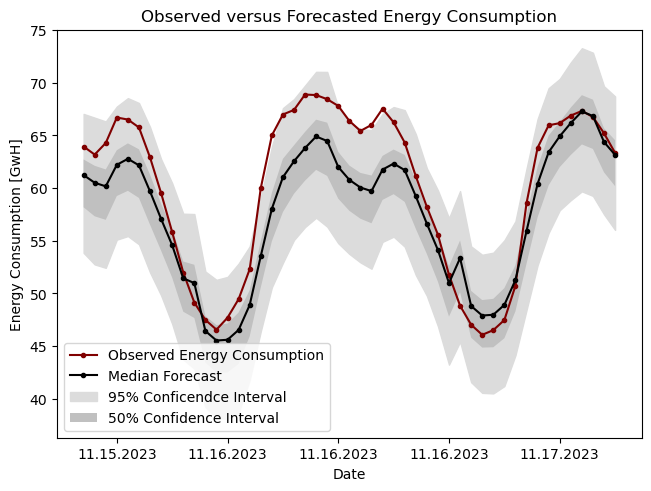

In [16]:
import matplotlib.pyplot as plt

dates = obs.index
dates = np.array(dates.strftime("%m.%d.%Y"))
x = np.array(range(len(dates)-1))

# determine 5 xticks
quotient = round(len(dates)/5)
ticks = [int(i * quotient - quotient * 0.7) for i in range(1, 6)]

# make figure + axes
fig, ax = plt.subplots(layout='constrained')
ax.set(title="Observed versus Forecasted Energy Consumption",
       xlabel="Date",
       ylabel="Energy Consumption [GwH]")

# plot observed ec and median ec
ax.plot(x, obs[1:], marker=".", color='maroon',
        label='Observed Energy Consumption')
ax.plot(x, lasso_forecasts['q0.5'][1:], marker='.',
        color='black', label='Median Forecast')

# fill in confidence intervals
ax.fill_between(x, lasso_forecasts['q0.025'][1:],
                lasso_forecasts['q0.975'][1:],
                color='gainsboro', label='95% Conficendce Interval')
ax.fill_between(x, lasso_forecasts['q0.25'][1:],
                lasso_forecasts['q0.75'][1:],
                color='silver', edgecolor=None, label='50% Confidence Interval')

# set x-axis ticks directly using dates
ax.set_xticks(ticks, labels=[dates[i] for i in ticks])
ax.legend()
len(dates) == len(x)

PIT Value

In [29]:
quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
quantiles

[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [32]:
lasso_forecasts_pit = get_Lasso_forecasts(energydata[:-168], indexes=list(range(
    80)), quantiles = quantiles, abs_eval=True)
lasso_forecasts_pit
obs_pit = energydata[-168:-86]

did you update weather and index?
2017-09-16 10:00:00
2023-11-16 12:00:00
did you update weather and index?
2023-11-15 13:00:00
2023-11-20 16:00:00


In [33]:
lasso_forecasts_pit

,date_time,q0,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1
0,2023-11-15 13:00:00,-inf,57.538794,58.953558,59.973703,60.845380,62.447403,62.474849,63.346525,64.366670,65.781435,inf
1,2023-11-15 14:00:00,-inf,56.130809,57.610464,58.677400,59.589058,61.228450,61.293266,62.204923,63.271859,64.751515,inf
2,2023-11-15 15:00:00,-inf,55.160805,56.723932,57.851056,58.814143,60.501605,60.614490,61.577577,62.704701,64.267828,inf
3,2023-11-15 16:00:00,-inf,54.831746,56.390587,57.514620,58.475066,60.160059,60.270476,61.230921,62.354955,63.913796,inf
4,2023-11-15 17:00:00,-inf,57.286529,58.703751,59.725667,60.598857,62.202296,62.231157,63.104347,64.126263,65.543485,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
75,2023-11-18 16:00:00,-inf,51.518033,53.104994,54.249304,55.227074,56.928262,57.054872,58.032643,59.176953,60.763913,inf
76,2023-11-18 17:00:00,-inf,53.956781,55.407627,56.453789,57.347696,58.970498,59.018723,59.912630,60.958792,62.409638,inf
77,2023-11-18 18:00:00,-inf,54.312991,55.837565,56.936891,57.876224,59.541484,59.632167,60.571500,61.670825,63.195400,inf
78,2023-11-18 19:00:00,-inf,53.576620,55.141002,56.269030,57.232890,58.921074,59.034682,59.998541,61.126570,62.690951,inf


In [34]:
#obs_pit = obs_pit.reset_index()
obs_pit


In [112]:
merged_pit = lasso_forecasts_pit.merge(obs_pit, how='left', on = 'date_time')
merged_pit.columns

Index(['date_time', 'q0', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
       'q0.7', 'q0.8', 'q0.9', 'q1', 'energy_consumption'],
      dtype='object')

Idea: distribution for each horizon different --> does not make sense to find one whole cdf --> Just check if the observed value are equally distributed across the quantiles

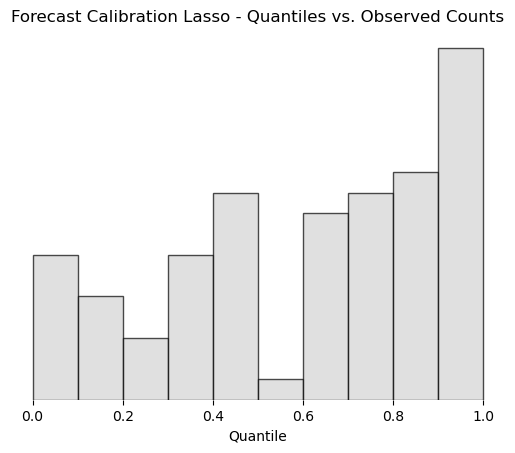

In [111]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'  # Default if energy_consumption is greater than q1


# Apply the function to each row
merged_pit['first_quantile'] = merged_pit.apply(find_first_quantile, axis=1)
quantile_counts = merged_pit['first_quantile'].value_counts()
quantile_counts = quantile_counts

ordered_quantile_counts = {}
for q in quantiles: 
    if f'q{q}' in quantile_counts.index: 
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']

counts = list(ordered_quantile_counts.values())
bar_width = 0.1  

# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])
# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration Lasso - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()

Idea: Not only for one time horizon to get more accurate results

In [115]:
pit_merged = pd.DataFrame(columns=['date_time', 'q0', 'q0.1', 'q0.2', 'q0.3', 'q0.4', 'q0.5', 'q0.6',
 'q0.7', 'q0.8', 'q0.9', 'q1', 'energy_consumption'])
pit_merged

,date_time,q0,q0.1,q0.2,q0.3,q0.4,q0.5,q0.6,q0.7,q0.8,q0.9,q1,energy_consumption


In [118]:
len(list(range(30,80)))

50

In [121]:
quantiles = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
for i in range(1,10):

    # consider specific forecasting horizon
    forecasts = get_Lasso_forecasts(energydata[:i*(-168)], indexes=list(range(30,
        80)), quantiles=quantiles, abs_eval=True)
    obs = energydata[i*(-168):i*(-168)+50].reset_index()
    forecasts_obs = forecasts.merge(obs, how='left', on='date_time')
    pit_merged = pd.concat([pit_merged, forecasts_obs])

did you update weather and index?
2017-09-16 10:00:00
2023-11-16 12:00:00
did you update weather and index?
2023-11-15 13:00:00
2023-11-20 16:00:00
did you update weather and index?
2017-09-09 10:00:00
2023-11-09 12:00:00
did you update weather and index?
2023-11-08 13:00:00
2023-11-13 16:00:00
did you update weather and index?
2017-09-02 10:00:00
2023-11-02 12:00:00
did you update weather and index?
2023-11-01 13:00:00
2023-11-06 16:00:00
did you update weather and index?
2017-08-26 10:00:00
2023-10-26 12:00:00
did you update weather and index?
2023-10-25 13:00:00
2023-10-30 16:00:00
did you update weather and index?
2017-08-19 10:00:00
2023-10-19 12:00:00
did you update weather and index?
2023-10-18 13:00:00
2023-10-23 16:00:00
did you update weather and index?
2017-08-12 10:00:00
2023-10-12 12:00:00
did you update weather and index?
2023-10-11 13:00:00
2023-10-16 16:00:00
did you update weather and index?
2017-08-05 10:00:00
2023-10-05 12:00:00
did you update weather and index?
2023

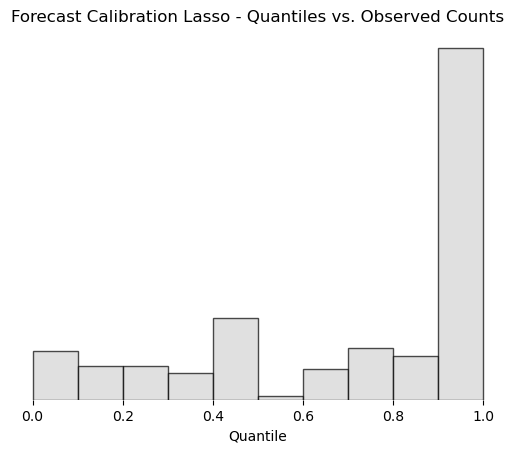

In [122]:
def find_first_quantile(row):
    quantile_columns = [f'q{quantile}' for quantile in quantiles]
    for quantile_col in quantile_columns:
        if row['energy_consumption'] < row[quantile_col]:
            return quantile_col
    return 'q1'  


# Apply the function to each row
pit_merged['first_quantile'] = pit_merged.apply(find_first_quantile, axis=1)
quantile_counts = pit_merged['first_quantile'].value_counts()

# order quantiles for final plot
ordered_quantile_counts = {}
for q in quantiles:
    if f'q{q}' in quantile_counts.index:
        ordered_quantile_counts[q] = quantile_counts.loc[f'q{q}']

counts = list(ordered_quantile_counts.values())
bar_width = 0.1

quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# Centering the bars on the left-hand side of their ticks
plt.bar([q - bar_width for q in quantiles], counts,
        width=bar_width, color='lightgrey', alpha=0.7, align='edge', edgecolor='black')
plt.xlabel('Quantile')
plt.yticks([])
# Alternatively: observed counts in each quantile range
plt.title('Forecast Calibration Lasso - Quantiles vs. Observed Counts')
plt.box(False)
plt.show()

## Ansatz 
* Dummies nicht standardisieren
* (Time frame verkleinern)
--> neues NB (übersichtlichkeit)